In [2]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import Dense, Flatten, Dropout
import glob
import matplotlib.pyplot as plt
import cv2
import numpy as np
import keras

Using TensorFlow backend.


In [2]:
image_size=[224,224]

In [3]:
def dataset(train_path,test_path):
    datagen = ImageDataGenerator()
    train_set = datagen.flow_from_directory(train_path, class_mode='categorical', batch_size=20,target_size=(224,224))
    test_set = datagen.flow_from_directory(test_path, class_mode='categorical', batch_size=20,target_size=(224,224))
    return train_set,test_set

In [4]:
def model_creation(model_name):
    
    vgg_model = model_name(weights='imagenet', include_top=False, input_shape=image_size + [3])
    
    for layer in vgg_model.layers:
        layer.trainable=False    
    data=glob.glob("dataset/Train/*")
    xx=Dropout(rate=0.20)(vgg_model.output)
    x=Flatten()(xx)
    prediction=Dense(len(data),activation="softmax")(x)
    model=Model(inputs=vgg_model.input , outputs=prediction)
    model.summary()
    
    return model
    

# Loading the model

In [5]:
model=model_creation(VGG16)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________

# Loading Dataset

In [6]:
train="dataset/Train/"
test="dataset/test/"
train_set,test_set=dataset(train,test)

Found 840 images belonging to 2 classes.
Found 645 images belonging to 2 classes.


# Model training

In [ ]:
model.compile(loss="categorical_crossentropy",optimizer='adam',metrics=['accuracy'])
history=model.fit(train_set,validation_data=test_set,epochs=5,shuffle=True)

Epoch 1/5
42/42 [==============================] - 423s 10s/step - loss: 2.8482 - acc: 0.9310 - val_loss: 0.2915 - val_acc: 0.9876
Epoch 2/5
 3/42 [=>............................] - ETA: 3:23 - loss: 0.0000e+00 - acc: 1.0000

# Ploting Accuracy and Loss

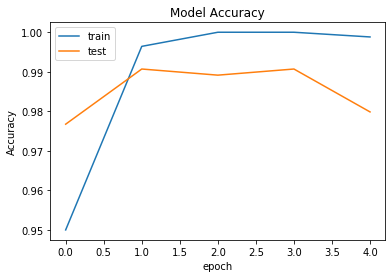

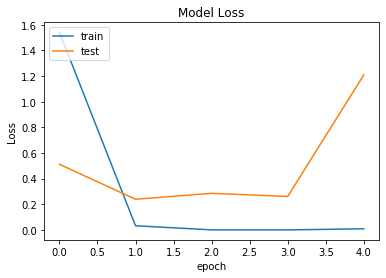

In [28]:
plt.plot(history.history["acc"])
plt.plot(history.history["val_acc"])
plt.title("Model Accuracy")
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
         
         
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [28]:
model.save("Face_Mask.h5") #saving trained model

In [73]:
(train_set.class_indices)

{'WithMask': 0, 'WithoutMask': 1}

# Testing Model with different images

In [13]:
def pre(image_name):
    face_cascade = cv2.CascadeClassifier('face.xml')
    img = cv2.imread(image_name)
    RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    faces = face_cascade.detectMultiScale(RGB_img, 1.1,3)
    for (x, y, w, h) in faces:
        cv2.rectangle(RGB_img, (x, y), (x+w, y+h), (255, 255, 0), 1)
    crop=RGB_img[y:y + h, x:x + w]
    resized=cv2.resize(crop,(224,224))
    x = np.expand_dims(resized, axis=0)
    images = np.vstack([x])
    print(images.shape)
    pp=plt.imread(image_name)
    show=plt.imshow(pp)
    plt.imshow(crop)
    model=load_model("Face_Mask.h5")
    output=model.predict(images)
    print(output.argmax())
    if np.argmax(output, axis=-1)[0] == 0:
        print("Wearing Mask")
    else:
        print("Not wearing mask")
    
    return show

(1, 224, 224, 3)
1
Not wearing mask


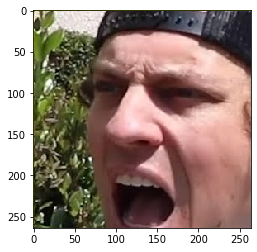

In [14]:
pre("two.png")

(1, 224, 224, 3)
1
Not wearing mask


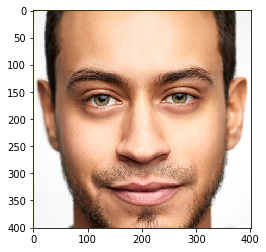

In [19]:
pre("graa.jpg")

(1, 224, 224, 3)
1
Not wearing mask


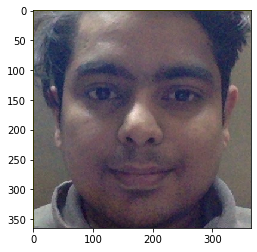

In [21]:
pre("mmm.jpg")

Not wearing mask


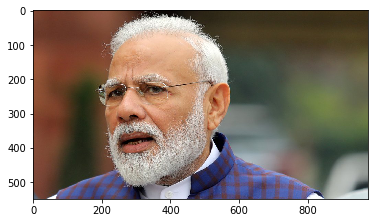

In [46]:
pre("mo.jpg")

# Real Time Detection

In [25]:
dic={1:'Not wearing Mask',0:"wearing mask"}
camera=cv2.VideoCapture(0)
model=load_model("Face_Mask.h5")
face_cascade = cv2.CascadeClassifier('face.xml')

while(True):
    ret,frame=camera.read()
    face=face_cascade.detectMultiScale(frame,1.2,5)
    
    for x,y,w,h in face:
        face_image=frame[y:y+w,x:x+w]
        resized=cv2.resize(face_image,(224,224))
        reshaped=np.reshape(resized,(1,224,224,3))
        result=model.predict(reshaped)
        cv2.rectangle(frame,(x,y),(x+w,y+h),(225,225,1),2)
        cv2.putText(frame,str(dic[result.argmax()]),(x,y-10),cv2.FONT_HERSHEY_COMPLEX,0.8,(23,225,2),2)
        
    cv2.imshow("frame",frame)
    interrupt = cv2.waitKey(1)
    
    
    
    if interrupt & 0xFF == 27: # esc key
        break


        
camera.release() 
# close all windows 
cv2.destroyAllWindows() 